# Integrated Model

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
def implicit_neighbours_movies(R, u):
    """ Calculate set of movies for which user u provided an implicit preference.

    Note:
        Apparently, for the netflix data implicit set is equal to 
        the explicit set.

    Parameters: 
    R (csr_matrix): Ratings matrix.
    S (2-D np.array): Similarity matrix.
    u (int): User's index.

    Returns: 
    (1-D np.array): Set of movies for which ratings by user u are available.
    """

    return [i for i in range(R.shape[1]) if R[u, i]]

In [0]:
from scipy.stats import pearsonr

def number_user(R_i, R_j):
    """ Calculate number of users that rated both movie i and movie j.

    Parameters:
        R_i (1-D np.array): Variable i (i-th movie).
        R_j (1-D np.array): Variable j (j-th movie).

    Returns:
        n_ij (float): Number of users that rated both movie i and movie j.

    """

    n_ij = 0
    for a, b in zip(R_i, R_j):
        if a and b :  # Increment n_ij if both ratings are not equal to zero
            n_ij += 1
            
    return n_ij

In [0]:
def similarity_matrix(R, lambda_2=100):
    """ Calculate the similarity

    Parameters: 
    R (csr_matrix): Ratings matrix.
    lamdba_1 (float): Regulation coefficient. 
  
    Returns: 
    S (array): Similarity matrix

    """

    R = R.tocsr()
    n = R.shape[1]
    S = np.zeros((n, n))
    for i in range(n):
        R_i = R[:, i].toarray()  # i-th variable's data
        v_i = [v[0] for v in R_i]  # We're using lists since we can't  multiply a sequence by a float 
        for j in range(i+1):
            R_j = R[:, j].toarray()  # j-th variable's data
            v_y = [v[0] for v in R_j] 
            
            # Calculate number of users that rated both i and j
            n_ij = number_user(R_i, R_j)

            # Calculate S_ij using the giving formula
            S[i, j], _ = (n_ij / (n_ij + lambda_2))*np.asarray(pearsonr(v_i, v_y))
    S += S.T
    
    return S

In [0]:
def k_explicit_neighbours(R, S, u, i, k):
    """ Calculate set of movies for which ratings by user u are available.

    Parameters: 
    R (csr_matrix): Ratings matrix.
    S (2-D np.array): Similarity matrix.
    u (int): User's index.
    i (int): Movie's index.
    k (int): Number of movie's neighbours to consider.

    Returns: 
    R_iu_k (1-D np.array): Set of k nearest movies for which 
                       ratings by u are available.
    """

    S_i = S[:, i]
    R_ui = {} # Dictionnary: Movie_index -> similarity with movie i if r_ui > 0

    for j in range(len(S_i)):
        if R[u, j] > 0:  # Add movie and it's similarity to i if u has given a rating
            R_ui[j] = S_i[j]

    # Remove i if it's one of the selected neighboors
    if i in R_ui:
        del R_ui[i]
    
    # Sort by similarity and keep the first k indices
    R_iu_k = [v[0] for v in 
             sorted(R_ui.items(), key=lambda x: x[1], reverse=True)[:k]]

    return R_iu_k

In [0]:
def k_implicit_neighbours_movies(R, S, u, i, k):
    """ Calculate set of movies for which user u provided an implicit preference.

    Note:
        Apparently, for the netflix data implicit set is equal to 
        the explicit set.

    Parameters: 
    R (csr_matrix): Ratings matrix.
    S (2-D np.array): Similarity matrix.
    u (int): User's index.
    i (int): Movie's index.
    k (int): Number of movie's neighbours to consider.

    Returns: 
    N_iu_k (1-D np.array): Set of k nearest movies for which 
                       ratings by u are available.
    """
    
    N_iu_k = k_explicit_neighbours(R, S, u, i, k)
    
    return N_iu_k

In [0]:
def gradient_J(
    R, S, f, k, B_i, B_u, mu, P, Q, Y, W, C, lambda_6, lambda_7, lambda_8):
    """Calculate stochastic gradient descent for the Integrated model.

    Parameters:
        R (coo_matrix): Rating matrix.
        S (2-D np.array): Similarity matrix.
        f (int): Number of latent factors.
        k (int): Number of movie's neighbours to consider.
        B_i (1-D np.array): Observed deviation for each movie.
        B_u (1-D np.array): Observed deviation for each user.
        mu (float): Overall average rating.
        P (2-D np.array): Parameter that describes user u in terms 
                          of his belonging to f user categories.
        Q (2-D np.array): Parameter that represent for the movie i
                          the proportions of f genres that it contains.
        Y (2-D np.array): Parameter that representes each user u 
                          by the factor vector. 
        W (2-D np.array): Parameter associated to the similarity 
                          between movies i and j.
        C (2-D np.array): Parameter associated to the categories 
                          of movies i and j.
        lambda_6 (float): Penality coefficient.
        lambda_7 (float): Penality coefficient.
        lambda_8 (float): Penality coefficient.

    Returns:
        b_i (1-D np.array): Gradient of observed deviation for each movie.
        b_u (1-D np.array): Gradient of observed deviation for each user.
        p (2-D np.array): Gradient of the parameter that describes user u 
                          in terms of his belonging to f user categories.
        q (2-D np.array): Gradient of the parameter that represent for the 
                          movie i the proportions of f genres that it contains.
        y (2-D np.array): Gradient of the parameter that representes each 
                          user u by the factor vector. 
        w (2-D np.array): Gradient of the parameter associated to the 
                          similarity between movies i and j.
        c (2-D np.array): Gradient of the parameter associated to the 
                          categories of movies i and j.

    """

    users, items = R.nonzero()
    b_u, b_i =  np.zeros(len(B_u)), np.zeros(len(B_i))
    p, q =  np.zeros((len(P), f)), np.zeros((len(Q), f))
    y = np.zeros((len(Y), f))
    w = np.zeros((len(W), len(W)))
    c = np.zeros((len(C), len(C)))

    for u, i in zip(users, items):
        N_u = implicit_neighbours_movies(R, u)

        y_sum = np.zeros(f)
        for j in N_u:
            for d in range(f):
                y_sum[d] += Y[j, d] / np.sqrt(len(N_u))
        
        R_iu_k = k_explicit_neighbours(R, S, u, i, k)
        #N_i_u_k = k_implicit_neighbours_movies(R, S, u, i, k)
        N_iu_k = R_iu_k
        r_iu_k = sum((R[u, j] - B_u[u] - B_i[j] - mu)*W[i, j] 
                for j in R_iu_k)
        n_iu_k = sum([C[i, j] for j in N_iu_k])

        r = mu + B_u[u] + B_i[i] + \
            sum([Q[i, d] * (P[u, d] + y_sum[d]) for d in range(f)]) + \
            r_iu_k / np.sqrt(len(R_iu_k)) + \
            n_iu_k / np.sqrt(len(N_iu_k))

        e = R[u, i] - r

        b_u[u] += e - lambda_6*B_u[u]
        b_i[i] += e - lambda_6*B_i[i]

        for d in range(f):
            p[u, d] += Q[i, d]*e - lambda_7*P[u, d]
            q[i, d] += (P[u, d] + y_sum[d])*e - lambda_7*Q[i, d]
            for j in N_u:
                y[j, d] += Q[i, d]*e/np.sqrt(len(N_u)) - lambda_7*Y[j, d]

        for j in R_iu_k:
            w[i, j] += (R[u, j] - B_u[u] - B_i[j] - mu)*e/np.sqrt(len(R_iu_k)) - \
                        lambda_8*W[i, j]
        
        for j in N_iu_k:
            c[i, j] += e/np.sqrt(len(N_iu_k)) - lambda_8*C[i, j]

        
    return -2*b_i, -2*b_u, -2*p, -2*q, -2*y, -2*w, -2*c

In [0]:
def rmse(R, S, f, k, B_i, B_u, mu, P, Q, Y, W, C):
    """Calculate the root-mean-square deviation using the
       estimated parameters.

    Parameters:
        R (coo_matrix): Rating matrix.
        S (2-D np.array): Similarity matrix.
        f (int): Number of latent factors.
        k (int): Number of movie's neighbours to consider.
        B_i (1-D np.array): Observed deviation for each movie.
        B_u (1-D np.array): Observed deviation for each user.
        mu (float): Overall average rating.
        P (2-D np.array): Parameter that describes user u in terms 
                          of his belonging to f user categories.
        Q (2-D np.array): Parameter that represent for the movie i
                          the proportions of f genres that it contains.
        Y (2-D np.array): Parameter that representes each user u 
                          by the factor vector. 
        W (2-D np.array): Parameter associated to the similarity 
                          between movies i and j.
        C (2-D np.array): Parameter associated to the categories 
                          of movies i and j.

    Returns:
        error (float): RMSE error value.

    """

    users, items = R.nonzero()
    error = 0
    for u, i in zip(users, items):
        N_u = implicit_neighbours_movies(R, u)

        y_sum = np.zeros(f)
        for j in N_u:
            for d in range(f):
                y_sum[d] += Y[j, d] / np.sqrt(len(N_u))
        
        R_iu_k = k_explicit_neighbours(R, S, u, i, k)
        #N_i_u_k = k_implicit_neighbours_movies(R, S, u, i, k)
        N_iu_k = R_iu_k
        r_iu_k = sum((R[u, j] - B_u[u] - B_i[j] - mu)*W[i, j] 
                for j in R_iu_k)
        n_iu_k = sum([C[i, j] for j in N_iu_k])

        r = mu + B_u[u] + B_i[i] + \
            sum([Q[i, d] * (P[u, d] + y_sum[d]) for d in range(f)]) + \
            r_iu_k / np.sqrt(len(R_iu_k)) + \
            n_iu_k / np.sqrt(len(N_iu_k))

        error += pow(R[u, i] - r, 2)
    error = (1 / R.shape[0]) * error

    return error

In [0]:
def recreate_matrix(R, S, f, k, B_i, B_u, mu, P, Q, Y, W, C):
    """Recreate the matrix using estimated parameters.

    Parameters:
        R (coo_matrix): Rating matrix.
        S (2-D np.array): Similarity matrix.
        f (int): Number of latent factors.
        k (int): Number of movie's neighbours to consider.
        B_i (1-D np.array): Observed deviation for each movie.
        B_u (1-D np.array): Observed deviation for each user.
        mu (float): Overall average rating.
        P (2-D np.array): Parameter that describes user u in terms 
                          of his belonging to f user categories.
        Q (2-D np.array): Parameter that represent for the movie i
                          the proportions of f genres that it contains.
        Y (2-D np.array): Parameter that representes each user u 
                          by the factor vector. 
        W (2-D np.array): Parameter associated to the similarity 
                          between movies i and j.
        C (2-D np.array): Parameter associated to the categories 
                          of movies i and j.

    Returns:
        R_estimated (2-D np.array): Recreated rating matrix.

    """

    R = R.tocsr()
    R_estimated = np.zeros((len(B_u), len(B_i)))

    for u in range(len(B_u)):
        for i in range(len(B_i)):
            N_u = implicit_neighbours_movies(R, u)

            y_sum = np.zeros(f)
            for j in N_u:
                for d in range(f):
                    y_sum[d] += Y[j, d] / np.sqrt(len(N_u))
            
            R_iu_k = k_explicit_neighbours(R, S, u, i, k)
            #N_i_u_k = k_implicit_neighbours_movies(R, S, u, i, k)
            N_iu_k = R_iu_k
            r_iu_k = sum((R[u, j] - B_u[u] - B_i[j] - mu)*W[i, j] 
                    for j in R_iu_k)
            n_iu_k = sum([C[i, j] for j in N_iu_k])

            R_estimated[u, i] = mu + B_u[u] + B_i[i] + \
                sum([Q[i, d] * (P[u, d] + y_sum[d]) for d in range(f)]) + \
                r_iu_k / np.sqrt(len(R_iu_k)) + \
                n_iu_k / np.sqrt(len(N_iu_k))

    return R_estimated

In [0]:
def integrated_model(
    R, N, f, k, delta_1=0.007, delta_2=0.007, delta_3=0.001, lambda_2=100, 
    lambda_6=0.005, lambda_7=0.015, lambda_8=0.015, verbose=False, plot=True):
    """Estimate SVD++ model parameters using SGD.

    Parameters:
        R (coo_matrix): Rating matrix.
        N (int): Number of iterations.
        f (int): Number of latent factors.
        k (int): Number of movie's neighbours to consider.
        delta_1 (float): Learning rate.
        delta_2 (float): Learning rate.
        delta_3 (float): Learning rate.
        lambda_2 (float): Penality coefficient.
        lambda_6 (float): Penality coefficient.
        lambda_7 (float): Penality coefficient.
        lambda_8 (float): Penality coefficient.
        plot (boolean): Plot RMSE track if True.
        verbose (boolean): Print number of the current iteration at excecution.

    Returns:
        B_i_opt (1-D np.array): Optimal observed deviation for each movie.
        B_u_opt (1-D np.array): Optimal observed deviation for each user.
        P_opt (2-D np.array): Optimal value of the parameter that describes user
                              u in terms of his belonging to f user categories.
        Q_opt (2-D np.array): Optimal value of the parameter that represent for
                              the movie i the proportions of f genres that 
                              it contains.
        Y_opt (2-D np.array): Optimal value of the parameter that representes 
                              each user u by the factor vector.
        W_opt (2-D np.array): Optimal value of the parameter associated 
                              to the similarity between movies i and j.
        C_opt (2-D np.array): Optimal Pvalue of the parameter associated
                              to the categories of movies i and j.
        S (2-D np.array): Similarity matrix.


    """

    # Weight initialization
    B_u = 0 * np.random.rand(R.shape[0])
    B_i = 0 * np.random.rand(R.shape[1])
    P_u = 0 * np.random.rand(R.shape[0], f)
    Q_i = 0 * np.random.rand(R.shape[1], f)
    Y_j = 0 * np.random.rand(R.shape[0], f)
    W = 0 * np.random.rand(R.shape[1], R.shape[1])
    C = 0 * np.random.rand(R.shape[1], R.shape[1])

    # Logs initialization
    mse_track = np.zeros(N) 
    w_track = []

    # Calculate overall average rating value
    mu = R.data.mean()

    # Calculate similarity matrix
    S = similarity_matrix(R, lambda_2=lambda_2)

    # Convert R into a csr_matrix
    R = R.tocsr()

    # SDG on N iterations
    for i in range(N):
        if verbose:
            print("Iteration "+ str(i))
        
        # Calculate SGD 
        gradient = gradient_J(R, S, f, k, B_i, B_u, mu, P_u, Q_i, Y_j, W, C, 
                              lambda_6, lambda_7, lambda_8)
        B_i = B_i - delta_1 * gradient[0] 
        B_u = B_u - delta_1 * gradient[1]
        P_u = P_u - delta_2 * gradient[2]
        Q_i = Q_i - delta_2 * gradient[3]
        Y_j = Y_j - delta_2 * gradient[4]
        W = W - delta_3 * gradient[5]
        C = C - delta_3 * gradient[6]

        # Saving RMSE values
        mse_track[i] = rmse(R, S, f, k, B_i, B_u, mu, P_u, Q_i, Y_j, W, C)

        # Saving estimated parameters
        w_track.append([B_i, B_u, P_u, Q_i, Y_j, W, C])

        #if i>0 and pow(mse_track[i] - mse_track[i-1], 2) < pow(10, -6): break

    # Selecting the optimal parameters
    idx_min = np.argmin(mse_track) 
    B_i_opt = w_track[idx_min][0]
    B_u_opt = w_track[idx_min][1]
    P_u_opt = w_track[idx_min][2]
    Q_i_opt = w_track[idx_min][3]
    Y_j_opt = w_track[idx_min][4]
    W_u_opt = w_track[idx_min][5]
    C_u_opt = w_track[idx_min][6]

    # Ploting RMSE deviation if plot is True
    if plot:
        mse_track = np.array([float(round(mse,3)) for mse in mse_track])
        plt.figure(figsize = (20,8))
        plt.rcParams['axes.facecolor'] = 'orange'
        plt.grid(c='white')
        plt.plot(np.arange(0,N), mse_track, 'blue')
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.title('Minimum MSE = {:.4f} reached at iteration {}'.format(min(mse_track),idx_min+1), fontsize = 15)
        plt.axvline(x = idx_min, color = 'green')

    return B_i_opt, B_u_opt, P_u_opt, Q_i_opt, Y_j_opt, W_u_opt, C_u_opt, S

# Dump example

In [0]:
from scipy.sparse import coo_matrix
R = coo_matrix(np.array([
                [0, 3, 0, 4, 0, 5, 2],
                [1, 0, 0, 2, 1, 2, 0],
                [5, 2, 4, 5, 0, 0, 3],
                [3, 0, 0, 3, 5, 5, 1],
                [1, 0, 5, 0, 1, 1, 0],
                [2, 4, 1, 4, 2, 3, 0],
                [0, 0, 0, 2, 0, 0, 4],
                [1, 4, 4, 3, 3, 0, 2]]
))

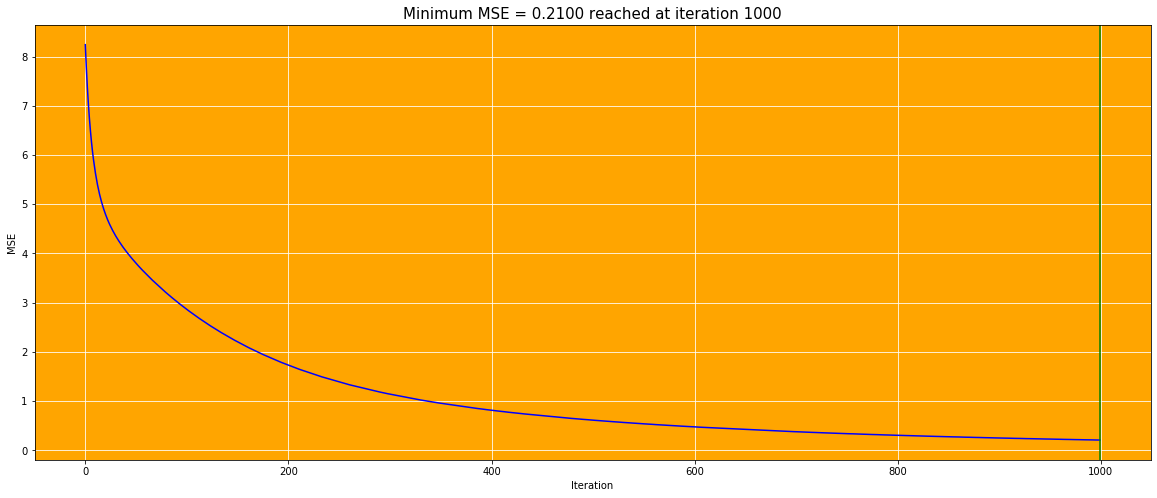

In [14]:
# Estimate Integrated model parameters using SGD.

B_i_opt, B_u_opt, P_u_opt, Q_i_opt, Y_j_opt, W_u_opt, C_u_opt, S = integrated_model(R, N=1000, k=3, f=3, delta_1=0.007, delta_2=0.007, delta_3=0.001, 
    lambda_2=100, lambda_6=0.005, lambda_7=0.015, lambda_8=0.015, plot=True)

In [0]:
# Recreate an estimated matrix using Integrated model's parameters.

recreate_matrix(R, S, 3, 3, B_i_opt, B_u_opt, R.data.mean(), P_u_opt, Q_i_opt, Y_j_opt, W_u_opt, C_u_opt) 

array([[3.17195856, 3.39597119, 3.94927975, 3.82256813, 3.67700253,
        4.35895216, 2.3994108 ],
       [0.79818355, 1.49585904, 2.03176149, 1.82092537, 1.47888317,
        2.04215738, 0.41894442],
       [3.90624927, 3.55296811, 4.2989189 , 4.42567964, 4.00906427,
        4.84325102, 2.75318402],
       [2.8439872 , 3.44291509, 3.85109948, 3.8547641 , 3.72194896,
        4.45175031, 2.18206887],
       [1.10020943, 2.2589393 , 3.46095786, 2.50739167, 1.43808929,
        1.93480853, 1.28931015],
       [2.13350266, 2.73553205, 2.77261889, 2.9468411 , 2.37859409,
        3.09273226, 1.22875153],
       [2.5479537 , 3.38985201, 3.81606512, 3.00120184, 3.47391603,
        4.04787727, 2.85267133],
       [2.20636264, 3.35894738, 3.51377559, 3.11508411, 2.89132956,
        3.69067973, 1.91382727]])

In [0]:
R.toarray()

array([[0, 3, 0, 4, 0, 5, 2],
       [1, 0, 0, 2, 1, 2, 0],
       [5, 2, 4, 5, 0, 0, 3],
       [3, 0, 0, 3, 5, 5, 1],
       [1, 0, 5, 0, 1, 1, 0],
       [2, 4, 1, 4, 2, 3, 0],
       [0, 0, 0, 2, 0, 0, 4],
       [1, 4, 4, 3, 3, 0, 2]], dtype=int64)

# Real application

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from scipy.sparse import save_npz, load_npz, coo_matrix

def load_matrix(M_name):
    """ Load previously saved sparce matrix M.

    Parameters:
        M_name (string): Matrix name as saved in drive (R, T or D).

    Returns:
        M (coo_matrix): Saved matrix.

    """

    M = load_npz("/content/drive/My Drive/Factorisation matricielle - dataset/training_set_csv/"+M_name+".npz")

    return M

In [0]:
# Loading R matrix

R = load_matrix("R")

In [0]:
import datetime
start = datetime.datetime.now()

B_i_opt, B_u_opt, P_u_opt, Q_i_opt, Y_j_opt, W_u_opt, C_u_opt, S = integrated_model(T, N=300, k=3, f=3, delta_1=0.007, delta_2=0.007, delta_3=0.001, 
    lambda_2=100, lambda_6=0.005, lambda_7=0.015, lambda_8=0.015, plot=True)

print("Parameters estimated in : {}".format(datetime.datetime.now() - start))

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [0]:
import datetime
start = datetime.datetime.now()

R_estimate = recreate_matrix(B_i_opt, B_u_opt, mu=R.data.mean())

print("Parameters estimated in : {}".format(datetime.datetime.now() - start))